# Example to connect to postgres

This is a tutorial to connect to our PostgreSQL database using python.

First you need to install the following libraries:
- psycopg2
- python-dotenv

Then you need to create a file with the name ".env". This file will contain the connection information and your credentials. This is an example:

```
DB_HOST=host_name
DB_NAME=postgres
DB_USER=my_user
DB_PASSWORD=my_password
DB_PORT=5432
```

After that you´re all set. We will import your credentials and connect to the database.

In [1]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [3]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [6]:
query_main="""
    select * 
    from agg.tidy_data
    where site = 64
"""
df_main = pd.read_sql_query(query_main, conn)

C:\Users\Zóra\AppData\Local\Temp\ipykernel_18288\3164986421.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_main = pd.read_sql_query(query_main, conn)


In [8]:
pd.set_option('display.max_columns', None)

In [9]:
df_main

,timestamp,site,year,month,day,hour,min,day_of_week,season,net_load,precipitation,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,weekend_or_bank_holiday,q25_net_load,q75_net_load,median_net_load
0,2019-06-01 03:15:00+00:00,64,2019,6,1,4,15,5,3,10.23,0.0,1.0,144,6.0,0.0,0.0,69.89,1,7.2925,53.9725,9.390
1,2019-06-01 03:30:00+00:00,64,2019,6,1,4,30,5,3,8.03,0.0,1.0,144,6.0,0.0,0.0,63.14,1,7.2100,44.3850,8.500
2,2019-06-01 03:45:00+00:00,64,2019,6,1,4,45,5,3,7.37,0.0,1.0,144,6.0,0.0,0.0,60.99,1,7.2725,55.3375,8.355
3,2019-06-01 04:00:00+00:00,64,2019,6,1,5,0,5,3,6.87,0.0,4.0,141,7.0,8.0,0.0,72.09,1,7.1450,54.3750,8.510
4,2019-06-01 04:15:00+00:00,64,2019,6,1,5,15,5,3,6.82,0.0,4.0,141,7.0,8.0,0.0,73.92,1,6.9925,56.1925,8.435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38049,2019-06-01 02:00:00+00:00,64,2019,6,1,3,0,5,3,8.58,0.0,0.0,150,6.0,0.0,0.0,81.12,1,7.2275,46.1050,8.345
38050,2019-06-01 02:15:00+00:00,64,2019,6,1,3,15,5,3,7.92,0.0,0.0,150,6.0,0.0,0.0,102.27,1,7.1000,61.0850,7.865
38051,2019-06-01 02:30:00+00:00,64,2019,6,1,3,30,5,3,8.94,0.0,0.0,150,6.0,0.0,0.0,79.69,1,7.0600,63.7400,8.730
38052,2019-06-01 02:45:00+00:00,64,2019,6,1,3,45,5,3,7.78,0.0,0.0,150,6.0,0.0,0.0,81.09,1,7.3425,53.9725,8.475


In [10]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38054 entries, 0 to 38053
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   timestamp                  38054 non-null  datetime64[ns, UTC]
 1   site                       38054 non-null  int64              
 2   year                       38054 non-null  int64              
 3   month                      38054 non-null  int64              
 4   day                        38054 non-null  int64              
 5   hour                       38054 non-null  int64              
 6   min                        38054 non-null  int64              
 7   day_of_week                38054 non-null  int64              
 8   season                     38054 non-null  int64              
 9   net_load                   38054 non-null  float64            
 10  precipitation              34790 non-null  float64            
 11  pr

## Convert Convert 'ts' to datetime and set as index

In [11]:
df_main['timestamp'] = pd.to_datetime(df_main['timestamp'])
df_main.set_index('timestamp', inplace=True)

In [12]:
df_main

,site,year,month,day,hour,min,day_of_week,season,net_load,precipitation,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,weekend_or_bank_holiday,q25_net_load,q75_net_load,median_net_load
timestamp,,,,,,,,,,,,,,,,,,,,
2019-06-01 03:15:00+00:00,64,2019,6,1,4,15,5,3,10.23,0.0,1.0,144,6.0,0.0,0.0,69.89,1,7.2925,53.9725,9.390
2019-06-01 03:30:00+00:00,64,2019,6,1,4,30,5,3,8.03,0.0,1.0,144,6.0,0.0,0.0,63.14,1,7.2100,44.3850,8.500
2019-06-01 03:45:00+00:00,64,2019,6,1,4,45,5,3,7.37,0.0,1.0,144,6.0,0.0,0.0,60.99,1,7.2725,55.3375,8.355
2019-06-01 04:00:00+00:00,64,2019,6,1,5,0,5,3,6.87,0.0,4.0,141,7.0,8.0,0.0,72.09,1,7.1450,54.3750,8.510
2019-06-01 04:15:00+00:00,64,2019,6,1,5,15,5,3,6.82,0.0,4.0,141,7.0,8.0,0.0,73.92,1,6.9925,56.1925,8.435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-01 02:00:00+00:00,64,2019,6,1,3,0,5,3,8.58,0.0,0.0,150,6.0,0.0,0.0,81.12,1,7.2275,46.1050,8.345
2019-06-01 02:15:00+00:00,64,2019,6,1,3,15,5,3,7.92,0.0,0.0,150,6.0,0.0,0.0,102.27,1,7.1000,61.0850,7.865
2019-06-01 02:30:00+00:00,64,2019,6,1,3,30,5,3,8.94,0.0,0.0,150,6.0,0.0,0.0,79.69,1,7.0600,63.7400,8.730


In [ ]:
# N.o. lags can be tuned according to model performance
number_of_lags = 3 
for lag in range(1, number_of_lags + 1):
    df_main[f'net_load_lag_{lag}'] = df_main['net_load'].shift(lag)

# Drop rows with NaN values created by lagging
df_main.dropna(inplace=True)

In [13]:
df_main

,site,year,month,day,hour,min,day_of_week,season,net_load,precipitation,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,weekend_or_bank_holiday,q25_net_load,q75_net_load,median_net_load
timestamp,,,,,,,,,,,,,,,,,,,,
2019-06-01 03:15:00+00:00,64,2019,6,1,4,15,5,3,10.23,0.0,1.0,144,6.0,0.0,0.0,69.89,1,7.2925,53.9725,9.390
2019-06-01 03:30:00+00:00,64,2019,6,1,4,30,5,3,8.03,0.0,1.0,144,6.0,0.0,0.0,63.14,1,7.2100,44.3850,8.500
2019-06-01 03:45:00+00:00,64,2019,6,1,4,45,5,3,7.37,0.0,1.0,144,6.0,0.0,0.0,60.99,1,7.2725,55.3375,8.355
2019-06-01 04:00:00+00:00,64,2019,6,1,5,0,5,3,6.87,0.0,4.0,141,7.0,8.0,0.0,72.09,1,7.1450,54.3750,8.510
2019-06-01 04:15:00+00:00,64,2019,6,1,5,15,5,3,6.82,0.0,4.0,141,7.0,8.0,0.0,73.92,1,6.9925,56.1925,8.435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-01 02:00:00+00:00,64,2019,6,1,3,0,5,3,8.58,0.0,0.0,150,6.0,0.0,0.0,81.12,1,7.2275,46.1050,8.345
2019-06-01 02:15:00+00:00,64,2019,6,1,3,15,5,3,7.92,0.0,0.0,150,6.0,0.0,0.0,102.27,1,7.1000,61.0850,7.865
2019-06-01 02:30:00+00:00,64,2019,6,1,3,30,5,3,8.94,0.0,0.0,150,6.0,0.0,0.0,79.69,1,7.0600,63.7400,8.730


## Train, Test, Validation

In [ ]:
# Number of 15-min intervals per day
n = 96

# To predict next day at the same time --> take data up to 1 day minus one interval
# to predict the net load for the next day at the same time 
#(for example, using data up to today at 1pm to predict tomorrow at 1pm)
# Need to shift test features by one day minus one interval because RF does not inherently handle the concept of a time step as ARIMA does
#intervals_per_day = 96
#n = intervals_per_day - 1

In [ ]:
#features = ['net_load_lag_1', 'net_load_lag_2', 'net_load_lag_3']
#train_features = df_main[features][:-n]
#test_features = df_main[features][-n:]

# We are predicting the net load itself so our target variable remains the same
#train_target = df_main['net_load'][n:]
#test_target = df_main['net_load'][:-n]

In [ ]:
features = ['net_load_lag_1', 'net_load_lag_2', 'net_load_lag_3']
y = df_main['net_load']
X = df_main[features]

train_size = int(len(df_main) * 0.2)
train_features, test_features = X.iloc[:train_size], X.iloc[train_size:]
train_target, test_target = y.iloc[:train_size], y.iloc[train_size:]


In [ ]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor()

# TRAIN the model
rf.fit(train_features, train_target)

# TEST the model - Predict on the test set - Make predictions for the test set
y_pred = rf.predict(test_features)


In [ ]:
# error metric MAE and normalized MAE
mae = mean_absolute_error(test_target, y_pred)
print(f'Mean Absolute Error: {mae}')

target_range = train_target.max() -train_target.min()
normalized_mae = mae / target_range
print(f'Normalized MAE: {normalized_mae}')

Mean Absolute Error: 22.28808087011783
Normalized MAE: 0.016773341614200868


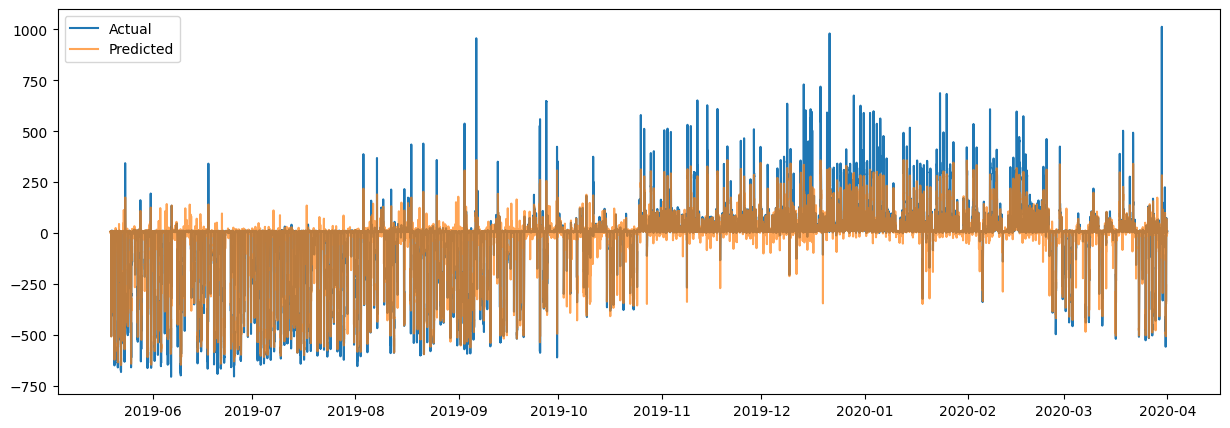

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(test_target.index, test_target, label='Actual')
plt.plot(test_target.index, y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.show()